In [1]:
import gymnasium
import torch
import os
import numpy as np
import mujoco
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import SubprocVecEnv, VecMonitor
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.monitor import Monitor
import matplotlib.pyplot as plt
from datetime import date, datetime
from stable_baselines3.common import results_plotter
from stable_baselines3.common.monitor import load_results
from stable_baselines3.common.results_plotter import plot_results
from stable_baselines3.common import results_plotter
from src import helpers
import importlib
from src.definitions import PROJECT_ROOT


In [2]:
n_envs = 7
start_time_suffix = datetime.now().strftime("%Y-%m-%d_%H-%M")
log_dir = f"logs/monitor_{start_time_suffix}/"


print(f"PyTorch CUDA available: {torch.cuda.is_available()}")
print(f"MuJoCo version: {mujoco.__version__}")

PyTorch CUDA available: True
MuJoCo version: 3.4.0


# MuJoCo Native Training Setup (CPU Optimized)
Using native MuJoCo simulation with vectorized environments for maximum CPU throughput.


In [3]:
xml_path = os.path.join(PROJECT_ROOT, "animals", "ant.xml")

# Verify model loads correctly
model = mujoco.MjModel.from_xml_path(xml_path)
data = mujoco.MjData(model)
print(f"Model loaded: {model.nq} DOFs, {model.nu} actuators")

Model loaded: 15 DOFs, 8 actuators


In [ ]:
vec_env = make_vec_env(
    "Ant-v5",
    n_envs=n_envs,
    env_kwargs={"xml_file": xml_path},
    vec_env_cls=SubprocVecEnv,
    monitor_dir=log_dir,
)

print(f"Created {n_envs} parallel environments")

In [ ]:
vec_env = VecMonitor(vec_env, log_dir)

model = PPO(
    "MlpPolicy",
    vec_env,
    verbose=1,
    device="cpu",  # Force CPU
    n_steps=2048,
    batch_size=256,  # Smaller batch for CPU
    n_epochs=10,
    gamma=0.99,
    gae_lambda=0.95,
    clip_range=0.2,
    ent_coef=0.0,
    learning_rate=3e-4,
)

model.learn(total_timesteps=6_000_000)

c:\GitHub\training-lucy\.venv\Lib\site-packages\stable_baselines3\common\vec_env\vec_monitor.py:44: UserWarning: The environment is already wrapped with a `Monitor` wrapperbut you are wrapping it with a `VecMonitor` wrapper, the `Monitor` statistics will beoverwritten by the `VecMonitor` ones.
  warnings.warn(


Using cpu device
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 81       |
|    ep_rew_mean     | -89.9    |
| time/              |          |
|    fps             | 5017     |
|    iterations      | 1        |
|    time_elapsed    | 2        |
|    total_timesteps | 14336    |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 106         |
|    ep_rew_mean          | -105        |
| time/                   |             |
|    fps                  | 4297        |
|    iterations           | 2           |
|    time_elapsed         | 6           |
|    total_timesteps      | 28672       |
| train/                  |             |
|    approx_kl            | 0.009562799 |
|    clip_fraction        | 0.0812      |
|    clip_range           | 0.2         |
|    entropy_loss         | -11.3       |
|    explained_variance   | -0.00404    |
|    learning

- model trains well after 4 million timestamps

In [ ]:
log_dir

'logs/monitor_2026-01-08_17-27/'

In [ ]:
df = load_results(log_dir)
df

,index,r,l,t
0,0,-9.166049,11.000000,5.685083
1,0,-9.166049,11.000000,5.685731
2,0,-30.863819,20.000000,5.698064
3,1,-30.863817,20.000000,5.698582
4,0,-14.786537,22.000000,5.700882
...,...,...,...,...
36006,17971,4098.907700,1000.000000,1558.224801
36007,17972,4208.456000,1000.000000,1558.288191
36008,17973,3520.859100,857.000000,1558.365740
36009,17974,768.480200,177.000000,1558.565221


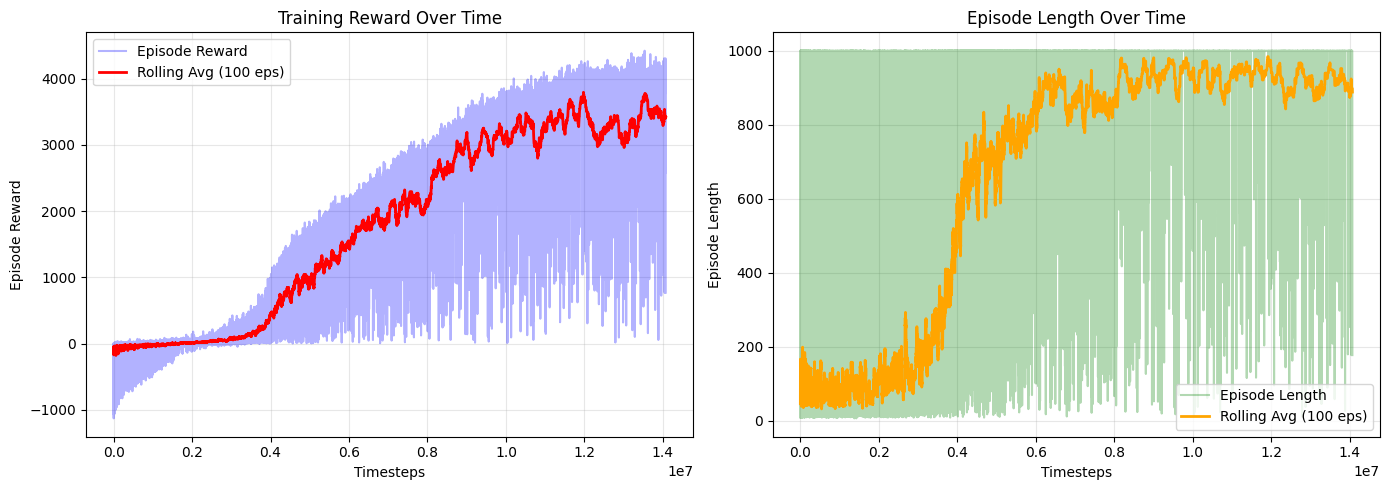

(<Figure size 1400x500 with 2 Axes>,
 array([<Axes: title={'center': 'Training Reward Over Time'}, xlabel='Timesteps', ylabel='Episode Reward'>,
        <Axes: title={'center': 'Episode Length Over Time'}, xlabel='Timesteps', ylabel='Episode Length'>],
       dtype=object))

In [ ]:
importlib.reload(helpers)

helpers.plot_training_progress(df)

In [ ]:
model_name = f"ppo_ant_{start_time_suffix}"

model.save(os.path.join(PROJECT_ROOT, "trained_models", model_name))
vec_env.close()

print(f"Model saved to trained_models/{model_name}")

Model saved to trained_models/ppo_ant_2026-01-08_17-27


In [ ]:
break

: 

: 

: 

In [ ]:
load_model = "trained_models/ppo_ant_2026-01-08_17-27.zip"

from src import render_model_gym
importlib.reload(render_model_gym)

render_model_gym.render_model_gym(load_model, xml_path)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


c:\GitHub\training-lucy\.venv\Lib\site-packages\stable_baselines3\common\on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


Torso body ID: 1


c:\GitHub\training-lucy\.venv\Lib\site-packages\glfw\__init__.py:917: GLFWError: (65537) b'The GLFW library is not initialized'
  warnings.warn(message, GLFWError)


KeyboardInterrupt: 